# 시계열 예측을 통한 이상치 발견

아래는 시계열 예측을 통한 이상치 발견을 위한 예제입니다. 앱 운영 중 API 사용량과 RDS 사용량 데이터를 활용하여 이상 현상을 사전에 감지하는 방법을 다룹니다.

## 문제 상황

앱 운영 중 발생하는 이상 현상을 사전에 감지하여 예지 보전을 하고자 합니다. 이를 위해 API 사용량과 RDS 사용량 데이터를 분석하여 정상 범위를 벗어나는 전조 증상을 사전에 발견하는 것이 목표입니다. 시계열 예측 기법을 사용하여 정상 시의 패턴을 학습하고, 이를 기반으로 예상 범위를 계산하여 이상치를 감지하는 방법을 설명합니다.

## 데이터 생성

우선, 예제 데이터를 생성해보겠습니다. 여기서는 API 사용량과 RDS 사용량의 시간 단위 데이터를 가정합니다.

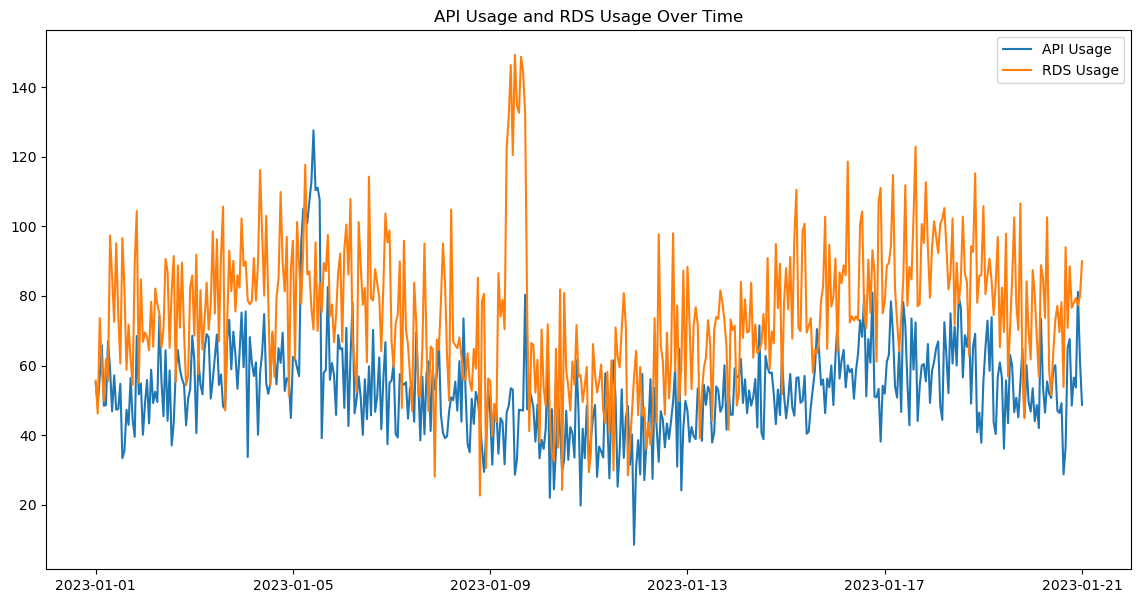

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# 랜덤 시드 설정
np.random.seed(42)

# 시간 범위 생성 (3주 동안의 시간 단위 데이터)
time_index = pd.date_range(start='2023-01-01', end='2023-01-21', freq='h')

# API 사용량과 RDS 사용량 데이터 생성
api_usage = np.random.normal(loc=50, scale=10, size=len(time_index))
rds_usage = np.random.normal(loc=70, scale=15, size=len(time_index))

# 데이터프레임 생성
data = pd.DataFrame(data={'API_Usage': api_usage, 'RDS_Usage': rds_usage}, index=time_index)

# 정상 패턴 추가 (저녁 시간에 사용량 증가, 밤 시간에 사용량 감소)
data['API_Usage'] += 10 * np.sin(np.linspace(0, 3*np.pi, len(time_index)))
data['RDS_Usage'] += 15 * np.sin(np.linspace(0, 3*np.pi, len(time_index)))

# 이상치 추가
data.iloc[100:110, 0] += 50  # API 사용량 이상치
data.iloc[200:210, 1] += 80  # RDS 사용량 이상치

# 데이터 시각화
plt.figure(figsize=(14, 7))
plt.plot(data['API_Usage'], label='API Usage')
plt.plot(data['RDS_Usage'], label='RDS Usage')
plt.legend()
plt.title('API Usage and RDS Usage Over Time')
plt.show()


## 시계열 예측 모델
이제 시계열 예측 모델을 사용하여 정상 시의 패턴을 학습합니다. 여기서는 LSTM 모델을 사용합니다.


In [2]:
# 예측 모델
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt

# 데이터 정규화
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 입력 특성과 타겟 분리
X = data_scaled[:, [1]]  # RDS 사용량을 입력 특성으로 사용
y_api = data_scaled[:, 0]  # API 사용량을 타겟으로 사용

# RandomForestRegressor 모델 정의 및 학습
model_api = RandomForestRegressor(n_estimators=100, random_state=42)
model_api.fit(X, y_api)

RandomForestRegressor(random_state=42)


## 예측 및 이상치 감지
학습된 모델을 사용하여 미래의 값을 예측하고, 예측된 값과 실제 값을 비교하여 이상치를 감지합니다.


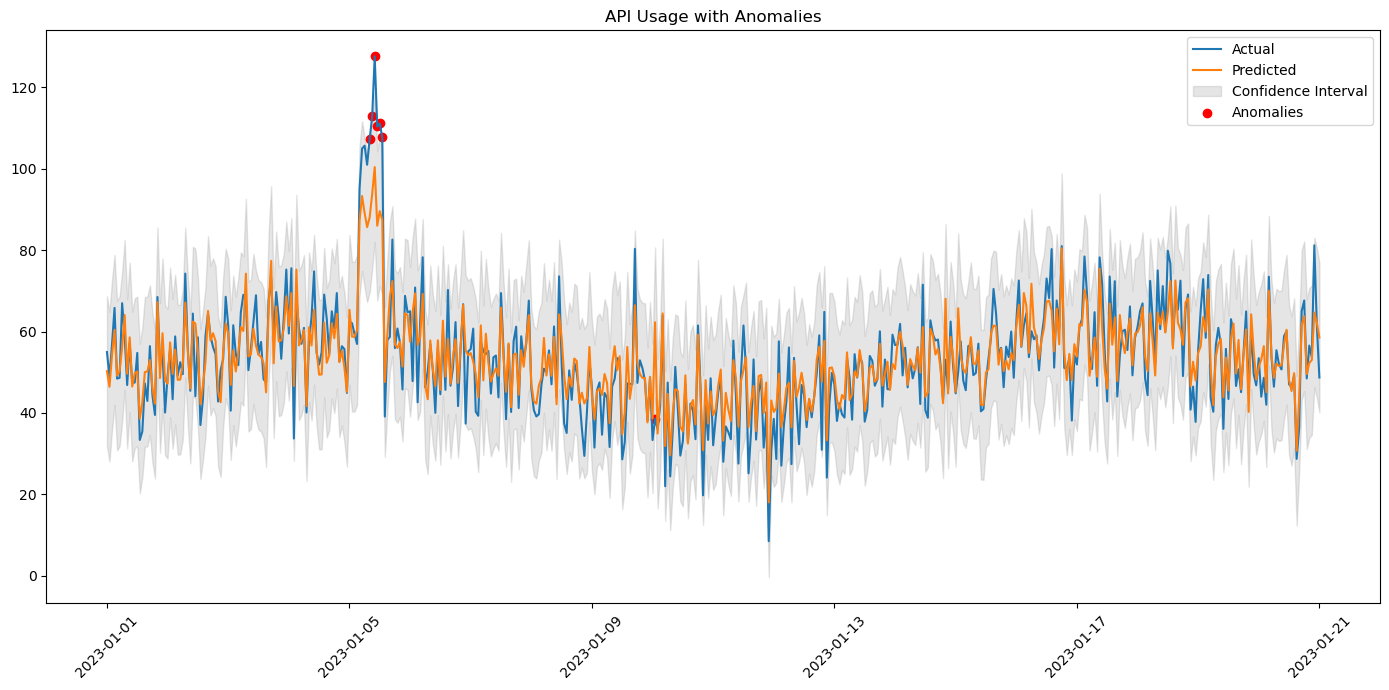

In [3]:
# 예측 수행
y_api_pred = model_api.predict(X)

# 신뢰 구간 계산
confidence_interval = 3
std_dev = np.std(y_api_pred - y_api)
upper_bound = y_api_pred + confidence_interval * std_dev
lower_bound = y_api_pred - confidence_interval * std_dev

# 이상치 감지
anomalies = np.logical_or(y_api > upper_bound, y_api < lower_bound)

# 시각화 함수 정의
def plot_anomalies_day(actual, predicted, upper_bound, lower_bound, title):
    plt.figure(figsize=(14, 7))
    actual = scaler.inverse_transform(np.column_stack((actual, np.zeros_like(actual))))[:, 0]
    predicted = scaler.inverse_transform(np.column_stack((predicted, np.zeros_like(predicted))))[:, 0]
    upper_bound = scaler.inverse_transform(np.column_stack((upper_bound, np.zeros_like(upper_bound))))[:, 0]
    lower_bound = scaler.inverse_transform(np.column_stack((lower_bound, np.zeros_like(lower_bound))))[:, 0]

    plt.plot(data.index, actual, label='Actual')
    plt.plot(data.index, predicted, label='Predicted')
    plt.fill_between(data.index, lower_bound, upper_bound, color='gray', alpha=0.2, label='Confidence Interval')
    plt.scatter(data.index[anomalies], actual[anomalies], color='red', label='Anomalies')
    plt.legend()
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# API 사용량 이상치 시각화 (특정 날짜)
plot_anomalies_day(y_api, y_api_pred, upper_bound, lower_bound, 'API Usage with Anomalies')

## 향후 고도화 및 활용 방안

* 활용 방안: 시계열 예측 모델을 통해 이상 현상이 감지되면, 사전에 유지보수를 계획하고 실행하여 시스템 다운타임을 최소화할 수 있습니다.
* 고도화: 위 모델 외에도 다양한 시계열 모델을 비교하여 성능을 평가하고 최적의 모델을 선택합니다. 더불어 다른 패턴의 이상 현상 또한 수집하여 학습 및 테스트 합니다.
* 배포 방안: 예측 모델을 실시간으로 구동하여 실시간 모니터링 및 알림 시스템 등을 구축합니다.